In [1]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize

import sympy as sp
from sympy.abc import x, y, a
from sympy.utilities.lambdify import lambdify
from sympy.vector import gradient
from sympy import hessian

# Функция Розенброка
Оптимизируем функцию Розенброка (https://ru.wikipedia.org/wiki/Функция_Розенброка). Сразу же найдём градиент и гессиан.

In [2]:
N = 10

F = (1 - x)**2 + (N*(y - x**2))**2

df_sym = []
for s in [x, y]:
    dfds_sym = F.diff(s)
    df_sym.append(lambdify((x, y), dfds_sym))
hess_sym = hessian(F, (x, y))

func = lambdify((x, y), F)
grad = lambda xv, yv: np.array([_(xv, yv) for _ in df_sym], dtype='float64')
hess = lambda xv, yv: np.array([_.subs({x:xv, y:yv}) for _ in hess_sym], dtype='float64').reshape((2,2))

In [3]:
def scalar_opt(f, x0, d):
    diff = f.subs({x: x0[0] + a*d[0], y: x0[1] + a*d[1]}).diff()
    diff = sp.simplify(diff)
    roots = sp.solveset(diff)
    m = np.inf
    r = 0.
    for s in roots:
        if s.is_real:
            fv = f.subs({x: x0[0] + s*d[0], y: x0[1] + s*d[1]})
            if fv < m:
                m = fv
                r = s
    return r

Методы оптимизации ниже:
* стохастический
* градиентный (1-го порядка)
* Ньютона (2-го порядка)
* Левенберга-Марквардта (Ньютон с регуляризацией)

Здесь метод Ньютона применяется в векторном виде к градиенту: мы ищем оптимум как ноль градиента

In [4]:
def opt_evolution(f, x0, y0, max_iter, eps):
    npop = 50      # population size
    sigma = 0.1    # noise standard deviation
    alpha = 0.1  # learning rate
    n = 2
    N = np.random.randn(npop, n)
    R = np.zeros(npop)
    
    fv = float(f.subs({x: x0, y: y0}))
    xs, ys, zs = [x0], [y0], [fv]
    
    while np.abs(fv) > eps and len(xs) < max_iter:
        for j in range(npop):
            x1 = x0 + sigma*N[j]
            R[j] = float(f.subs({x: x1[0], y: x1[1]}))
        A = (R - np.mean(R)) / np.std(R)
        dx = -alpha / (npop*sigma) * (N.T @ A)

        x1, y1 = x0 + dx[0], y0 + dx[1]
        fv = float(f.subs({x: x1, y: y1}))
        xs.append(x1)
        ys.append(y1)
        zs.append(fv)
        x0, y0 = x1, y1
    return xs, ys, zs


def opt_gradient(f, g, x0, y0, max_iter, eps):
    fv = float(f.subs({x: x0, y: y0}))
    gv = g(x0, y0)    
    xs, ys, zs = [x0], [y0], [fv]

    while np.abs(fv) > eps and len(xs) < max_iter:
        gv = g(x0, y0)

        alpha = scalar_opt(f, (x0, y0), gv)
        dx = alpha*gv
        
        x1, y1 = x0 + dx[0], y0 + dx[1]
        fv = float(f.subs({x: x1, y: y1}))
        xs.append(x1)
        ys.append(y1)
        zs.append(fv)
        x0, y0 = x1, y1
    return xs, ys, zs


def opt_newton(f, g, h, x0, y0, max_iter, eps):
    fv = float(f.subs({x: x0, y: y0}))
    gv = g(x0, y0)
    hv = h(x0, y0)
    xs, ys, zs = [x0], [y0], [fv]

    while np.abs(fv) > eps and len(xs) < max_iter:
        gv = g(x0, y0)
        hv = h(x0, y0)
        d = np.linalg.solve(-hv, gv)

        alpha = scalar_opt(f, (x0, y0), d)
        dx = alpha*d
        
        x1, y1 = x0 + dx[0], y0 + dx[1]
        fv = float(f.subs({x: x1, y: y1}))
        xs.append(x1)
        ys.append(y1)
        zs.append(fv)
        x0, y0 = x1, y1
    return xs, ys, zs


# При lam=0 вырождается в метод Ньютона, при lam->inf - в градиентный
def opt_levmarq(f, g, h, lam, x0, y0, max_iter, eps):
    fv = float(f.subs({x: x0, y: y0}))
    gv = g(x0, y0)
    hv = h(x0, y0)
    xs, ys, zs = [x0], [y0], [fv]

    while np.abs(fv) > eps and len(xs) < max_iter:
        gv = g(x0, y0)
        hv = h(x0, y0)
        d = np.linalg.solve(-(hv + lam*np.eye(*hv.shape)), gv)

        alpha = scalar_opt(f, (x0, y0), d)
        dx = alpha*d
        
        x1, y1 = x0 + dx[0], y0 + dx[1]
        fv = float(f.subs({x: x1, y: y1}))
        xs.append(x1)
        ys.append(y1)
        zs.append(fv)
        x0, y0 = x1, y1
    return xs, ys, zs

In [5]:
results = [
    opt_levmarq  (F, grad, hess, 5e-1, 9., 9., max_iter=100, eps=1e-3),
    opt_newton   (F, grad, hess,       9., 9., max_iter=100, eps=1e-3),
    opt_gradient (F, grad,             9., 9., max_iter=100, eps=1e-3),
    opt_evolution(F,                   9., 9., max_iter=100, eps=1e-3),
]

In [6]:
colors='rgbcmyk'
labels=['levmarq', 'newt', 'grad', 'evol']

<IPython.core.display.Javascript object>


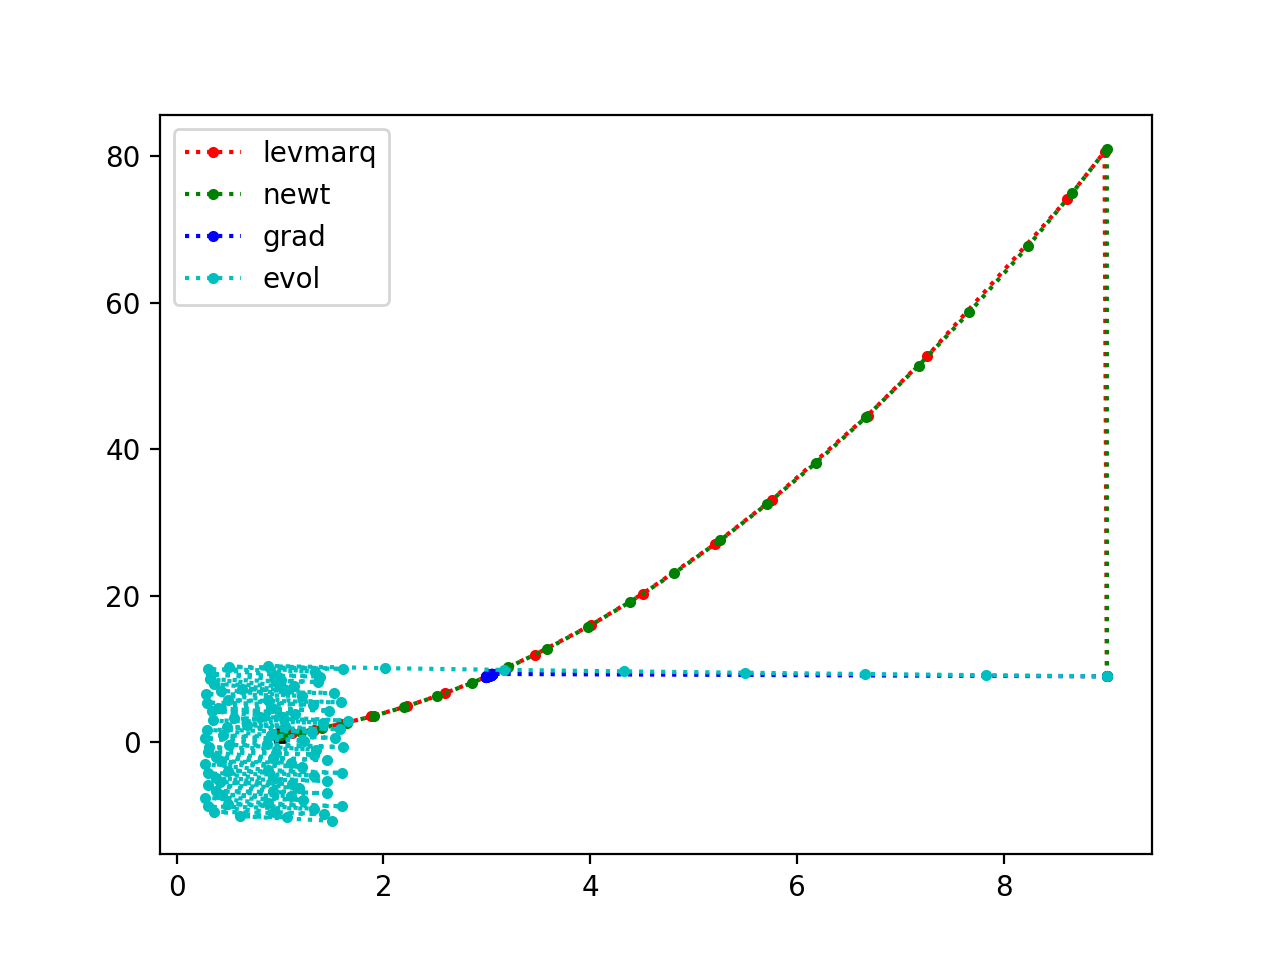

In [7]:
# вид сверху
plt.figure()
plt.plot(1, 1, 'kp')
for i, res in enumerate(results):
    plt.plot(res[0], res[1], f'{colors[i]}.:', label=labels[i])
plt.legend()
pass

<IPython.core.display.Javascript object>


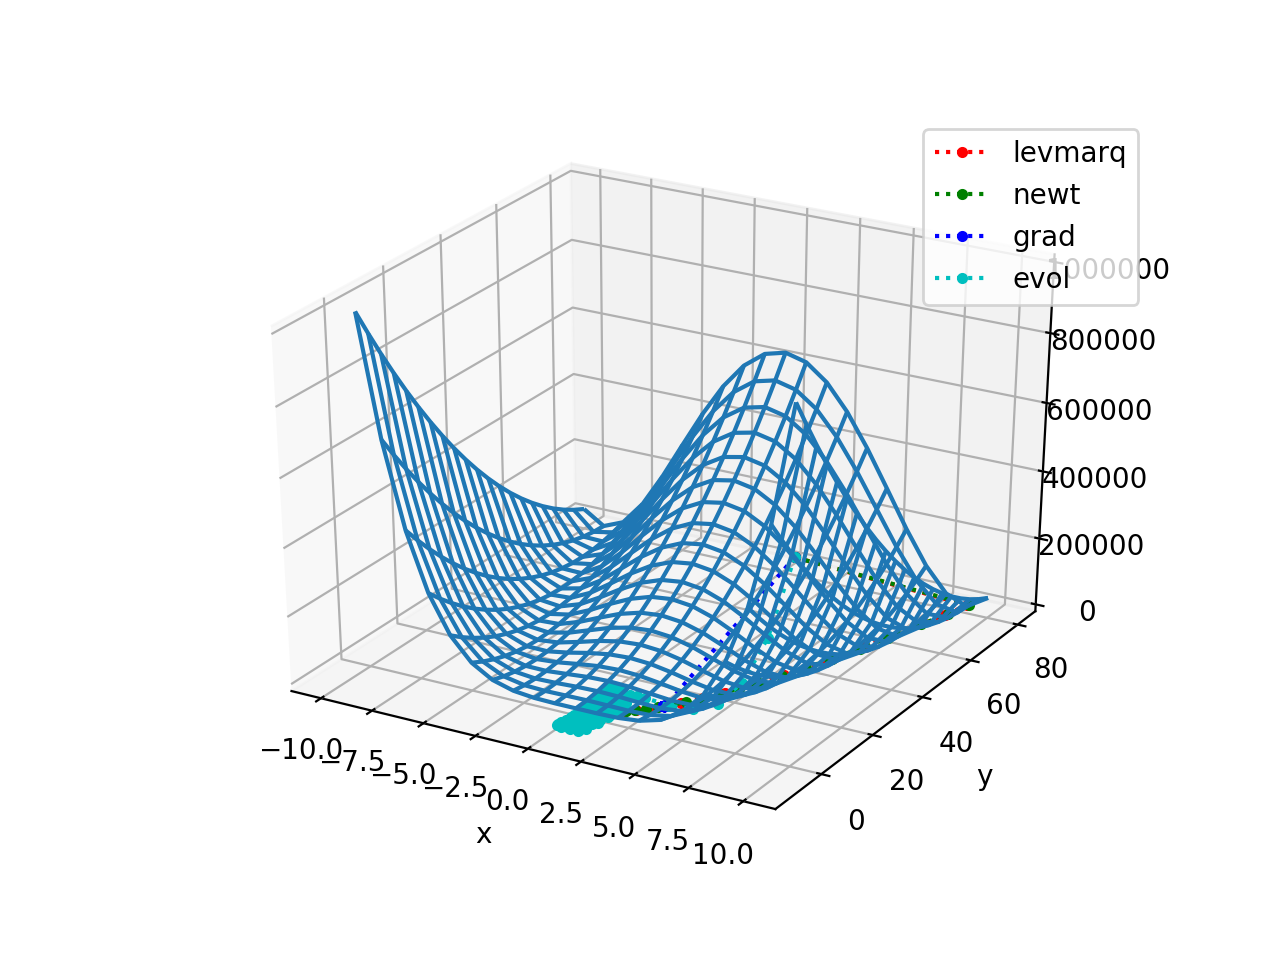

In [8]:
# 3d
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
xs = np.linspace(-10, 10, 21)
ys = np.linspace(0, 80, 21)
X, Y = np.meshgrid(xs, ys)
Z = X*0
for i, xv in enumerate(xs):
    for j, yv in enumerate(ys):
        Z[j,i] = func(xv, yv)
        
ax.plot_wireframe(X,Y,Z)
ax.plot([1],[1],[0],'mo')  # оптимум

# наш путь
for i, res in enumerate(results):
    ax.plot(res[0], res[1], res[2], f'{colors[i]}:.', label=labels[i])
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
pass

<IPython.core.display.Javascript object>


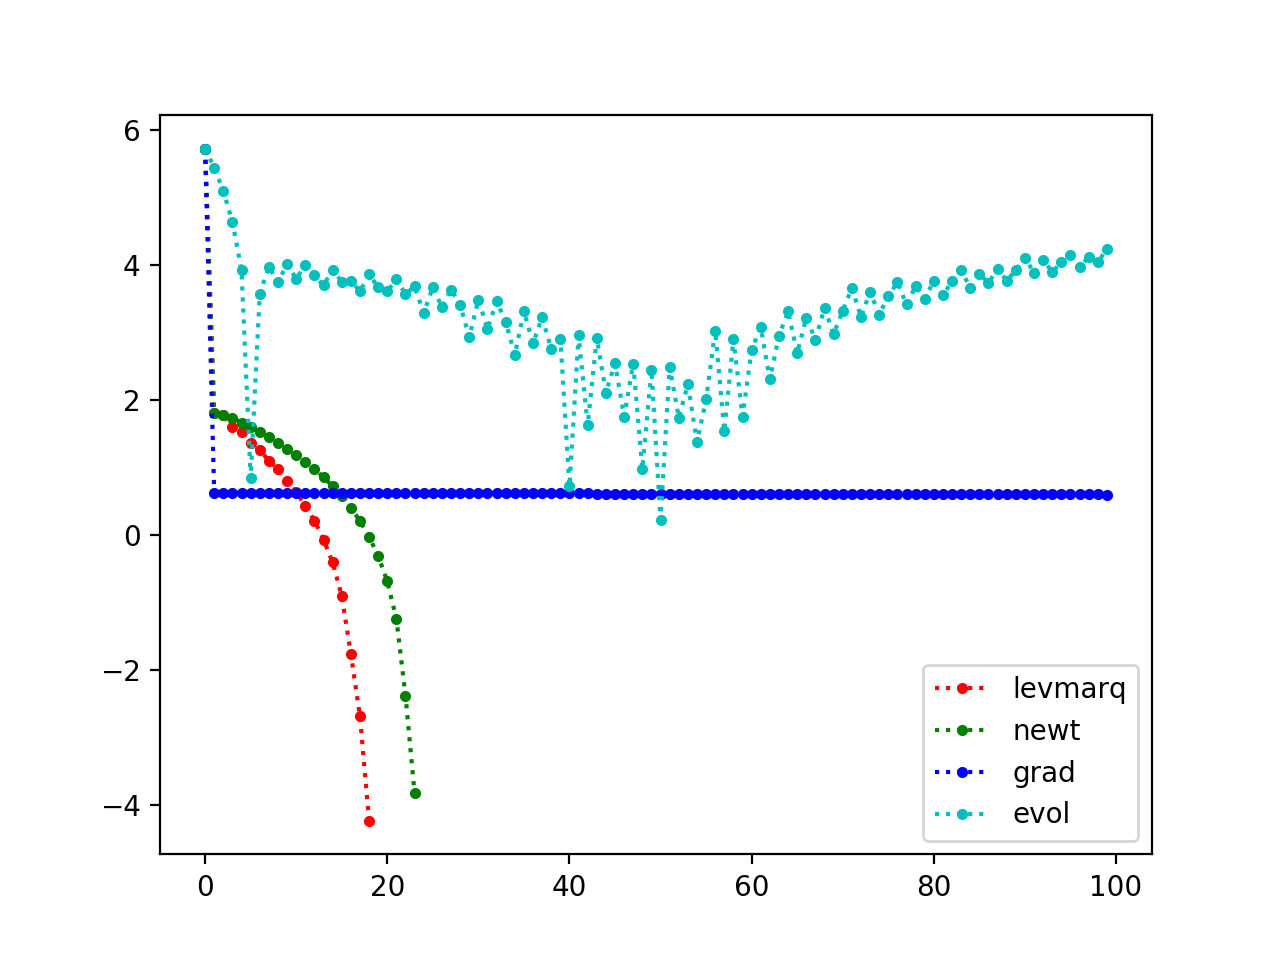

In [9]:
# acc
plt.figure()
for i, res in enumerate(results):
    plt.plot(np.log10(res[2]), f'{colors[i]}.:', label=labels[i])
plt.legend()
pass

А так можно ускорить сходимость (например, для градиентного метода)

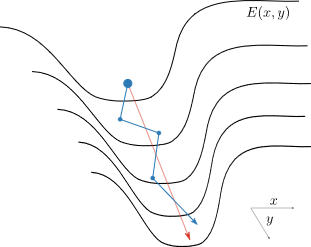